# Qubit spectroscopy: $T_1$ measurement example

This notebook demonstrates how to use the module `qubit_spectroscopy` to assess the "energy relaxation" time, $T_1$, of one or more qubits on a real quantum device using pyQuil. This one of the major sources of error on a quantum computer.


A $T_1$ experiment consists of an X pulse, bringing the qubit from $|0\rangle$ to $|1\rangle$ (the excited state of the artificial atom), followed by a delay of variable duration. 

The physics of the devices is such that we expect the state to decay exponentially with increasing time because of ["energy relaxation"](https://en.wikipedia.org/wiki/Relaxation_(NMR)). We characterize this decay by the `decay_time` constant, typically denoted $T_1 =1/\Gamma$ where $\Gamma$ is the decay rate. The parameter $T_1$ is referred to as the qubit's "relaxation" or "decoherence" time. A sample QUIL program at one data point (specified by the duration of the DELAY pragma) for qubit 0 with a 10us wait would look like 

    DECLARE ro BIT[1]
    RX(pi) 0
    PRAGMA DELAY 0 "1e-05"
    MEASURE 0 ro[0]

**NB: Since decoherence and dephasing noise are only simulated on gates, and we make use of DELAY pragmas to simulate relaxation time, we cannot simulate decoherence on the QPU with this experiment as written. This notebook should only be run on a real quantum device.**

setup - imports and relevant units

In [1]:
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer

from forest.benchmarking.qubit_spectroscopy import (
    generate_t1_experiments,
    acquire_qubit_spectroscopy_data,
    fit_t1_results, get_stats_by_qubit)

We treat SI base units, such as the second, as dimensionless, unit quantities, so we define relative units, such as the microsecond, using scientific notation. 

In [2]:
MICROSECOND = 1e-6

**Get a quantum computer**

In [3]:
# use this command to get the real QPU
#qc = get_qc('Aspen-1-15Q-A')

qc = get_qc('2q-noisy-qvm') # will run on a QVM, but not meaningfully 
qubits = qc.qubits()
qubits

[0, 1]

## Generate simultaneous $T_1$ experiments

We make and experiment for each desired qubit in `qubits`, specifying the times in seconds at which we would like to measure the decay.

In [4]:
import numpy as np
stop_time = 60 * MICROSECOND
num_points = 15
times = np.linspace(0, stop_time, num_points)
expt = generate_t1_experiments(qubits, times)
print(expt)

[<forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14a89c040>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71b1c0>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71b580>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71b940>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71bd00>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71d160>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71d580>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71d9a0>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c71ddc0>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c720220>, <forest.benchmarking.observable_estimation.ObservablesExperiment object at 0x14c720640>, <forest.benchmarking

## Acquire data

Collect our $T_1$ raw data using `acquire_qubit_spectroscopy_data`. 

In [5]:
num_shots = 1000
results = acquire_qubit_spectroscopy_data(qc, expt, num_shots)

## Analyze and plot

**Use the results to produce estimates of $T_1$**

In the cell below we first extract lists of expectations and std_errs from the results and store them separately by qubit. For each qubit we then fit to an exponential decay curve and evaluate the `decay_time` constant, i.e. the T1. Finally we plot the decay curve fit over the data for each qubit.

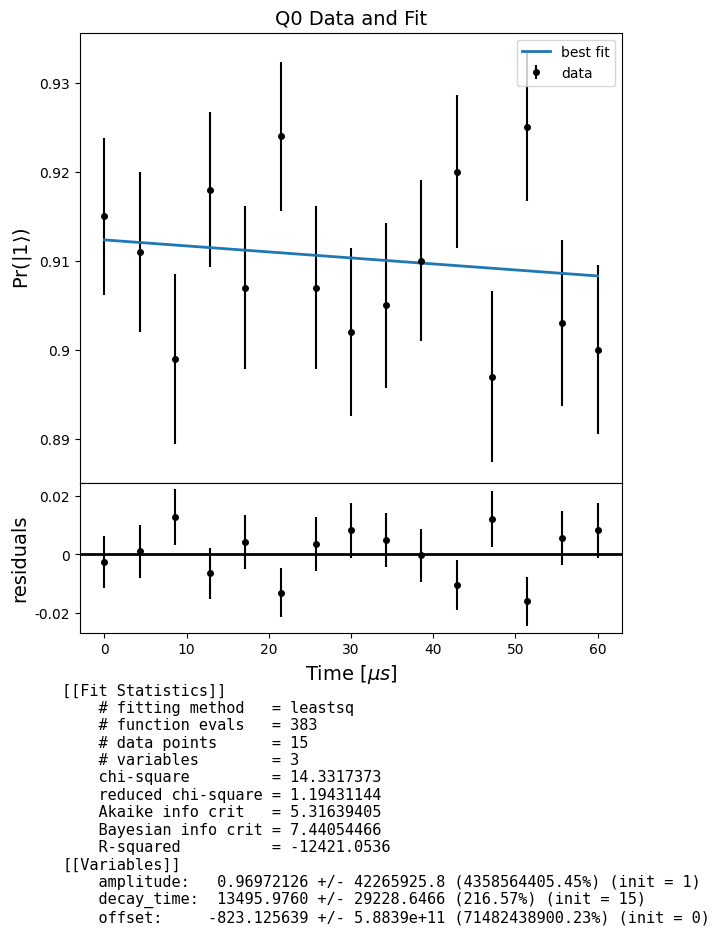

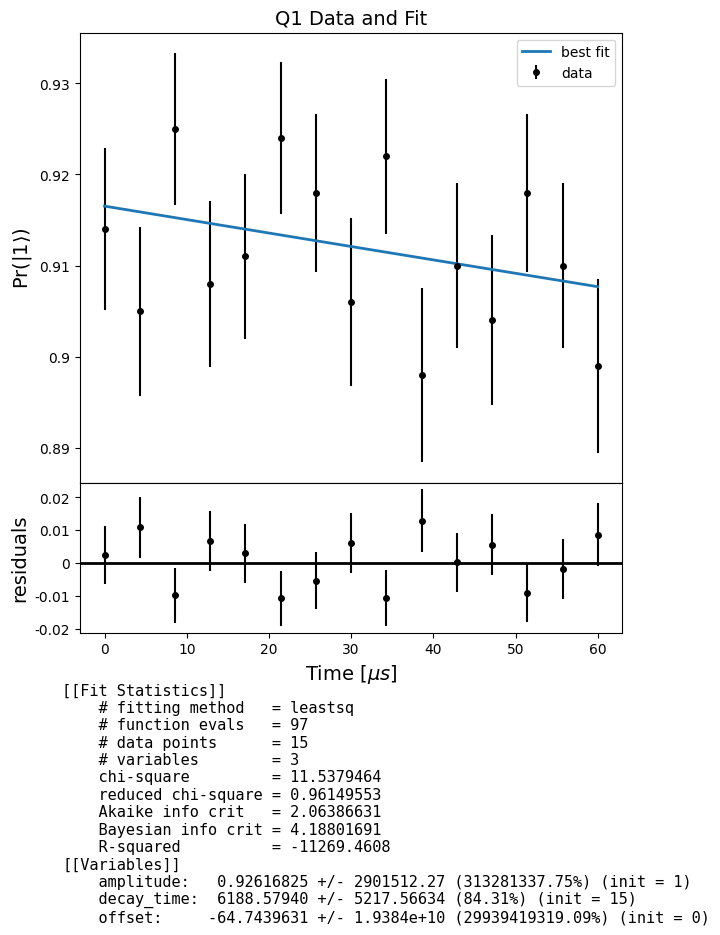

In [6]:
from forest.benchmarking.plotting import plot_figure_for_fit

stats_by_qubit = get_stats_by_qubit(results)
for q, stats in stats_by_qubit.items():
    fit = fit_t1_results(np.asarray(times) / MICROSECOND, stats['expectation'],
                         stats['std_err'])
    fig, axs = plot_figure_for_fit(fit, title=f'Q{q} Data and Fit', xlabel=r"Time [$\mu s$]",
                           ylabel=r"Pr($|1\rangle$)")
    t1 = fit.params['decay_time'].value # in us